In [53]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [54]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [55]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [56]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [ ]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
big_df

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
161451,0.0,16,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,5
161452,0.0,16,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,5
161453,0.0,16,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,5
161454,0.0,16,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.0,5


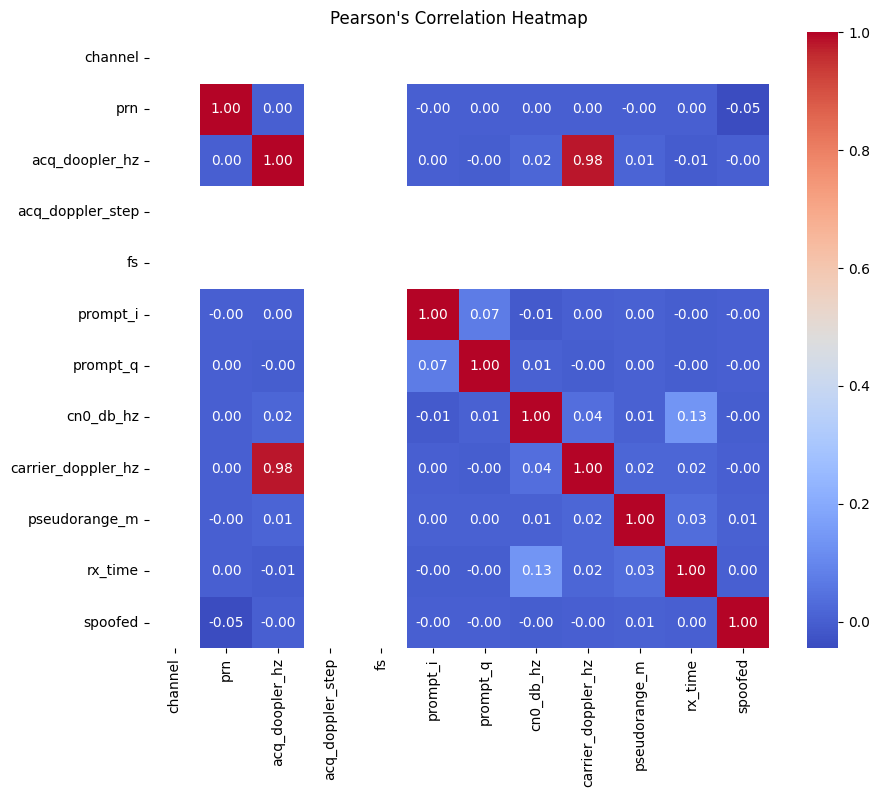

In [58]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [59]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [60]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


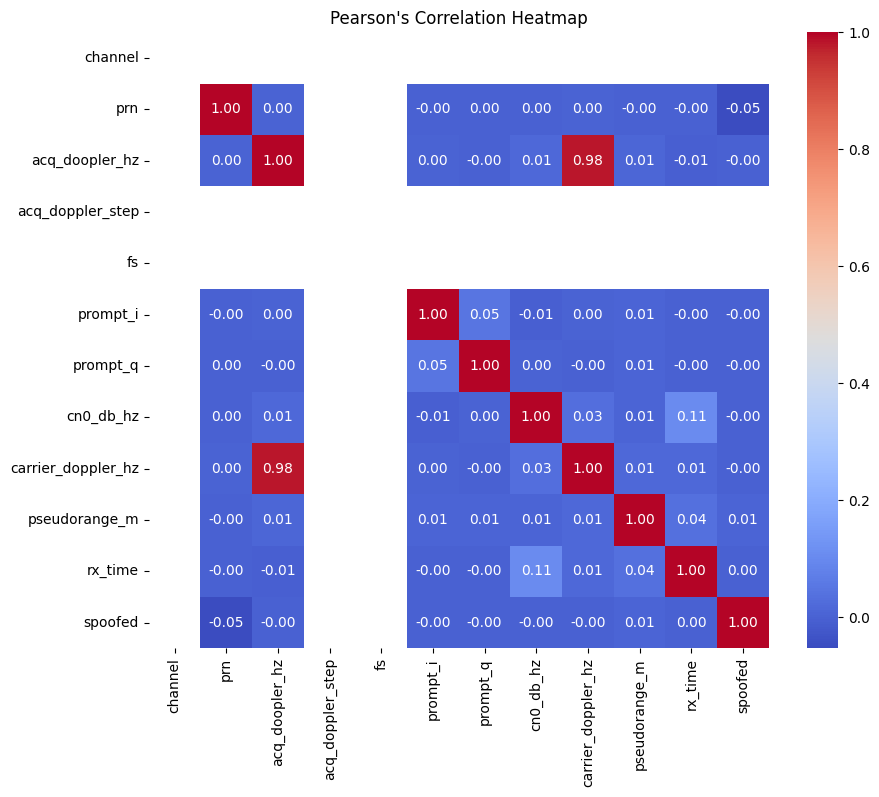

In [61]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [62]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step']))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step']).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [63]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step']))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df.drop(columns=['channel', 'prn', 'spoofed', 'fs', 'acq_doppler_step']).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values


In [ ]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [65]:
X_train

,acq_doopler_hz,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time
100999,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
99615,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
138305,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
76056,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
104595,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
...,...,...,...,...,...,...,...
152648,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
129411,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
2082,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837
20859,0.000069,-0.000077,0.000123,0.001562,0.002356,-0.012164,-0.330837


In [66]:
model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, y_train)

SVC()

In [67]:
model_no_diff = SVC(kernel='rbf', C=1.0)
model_no_diff.fit(X_train_no_diff, y_train_no_diff)

SVC()

In [68]:
y_pred = model.predict(X_test)


In [69]:
y_pred_no_diff = model.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.37      0.03      0.06      5114
           1       0.45      0.10      0.17      5533
           2       0.56      0.02      0.04      5423
           3       0.33      0.03      0.06      5161
           4       0.30      0.04      0.07      5451
           5       0.18      0.93      0.30      5610

    accuracy                           0.20     32292
   macro avg       0.36      0.19      0.12     32292
weighted avg       0.36      0.20      0.12     32292



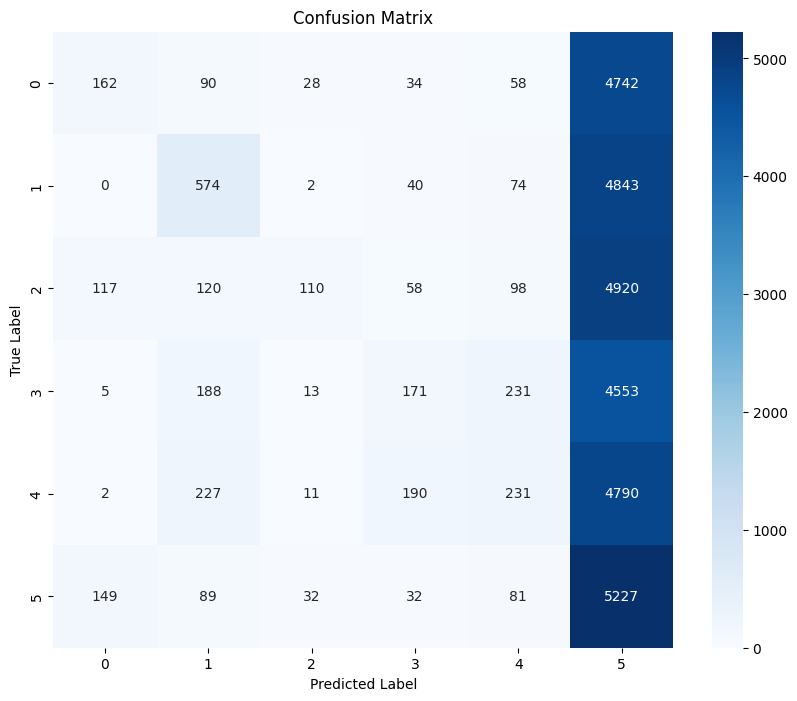

In [70]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.36      0.04      0.06      5120
           1       0.43      0.10      0.17      5381
           2       0.46      0.02      0.04      5420
           3       0.33      0.04      0.06      5233
           4       0.27      0.04      0.07      5529
           5       0.15      0.94      0.26      5587
           6       0.00      0.00      0.00      5585

    accuracy                           0.17     37855
   macro avg       0.29      0.17      0.10     37855
weighted avg       0.28      0.17      0.10     37855



C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Text(95.72222222222221, 0.5, 'True Label')

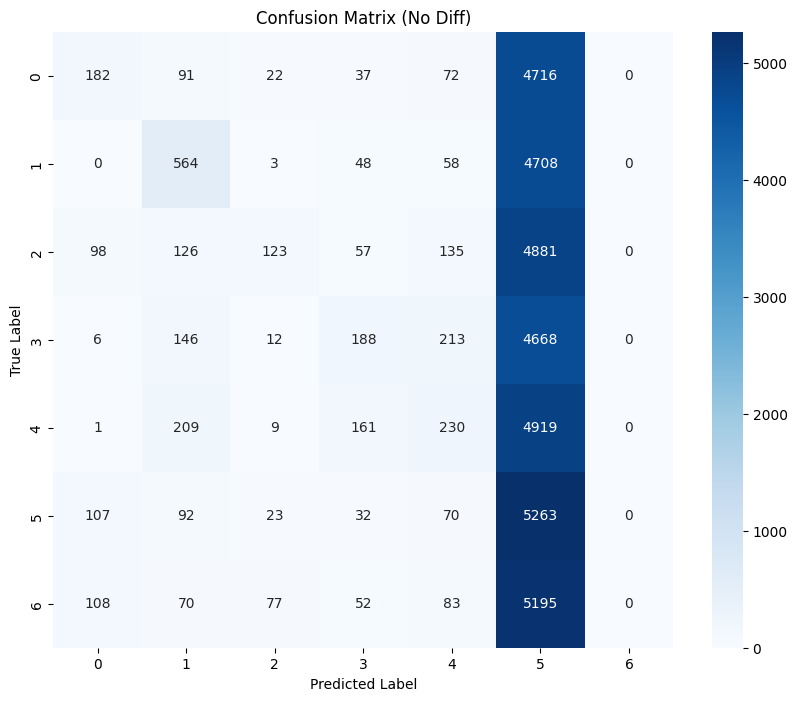

In [71]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [72]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10)
rf_model.fit(X_train, y_train)
rf_model_no_diff = RandomForestClassifier(n_estimators=1000, max_depth=3)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)



RandomForestClassifier(max_depth=3, n_estimators=1000)

In [73]:
y_pred = model.predict(X_test)
y_pred_no_diff = model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.37      0.03      0.06      5114
           1       0.45      0.10      0.17      5533
           2       0.56      0.02      0.04      5423
           3       0.33      0.03      0.06      5161
           4       0.30      0.04      0.07      5451
           5       0.18      0.93      0.30      5610

    accuracy                           0.20     32292
   macro avg       0.36      0.19      0.12     32292
weighted avg       0.36      0.20      0.12     32292



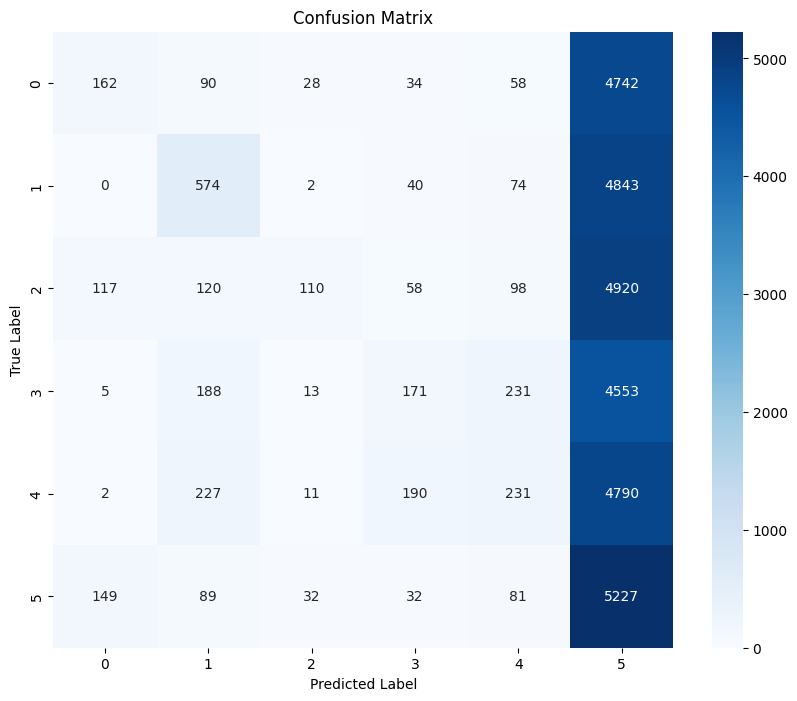

In [74]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.37      0.03      0.06      5114
           1       0.45      0.10      0.17      5533
           2       0.56      0.02      0.04      5423
           3       0.33      0.03      0.06      5161
           4       0.30      0.04      0.07      5451
           5       0.18      0.93      0.30      5610

    accuracy                           0.20     32292
   macro avg       0.36      0.19      0.12     32292
weighted avg       0.36      0.20      0.12     32292



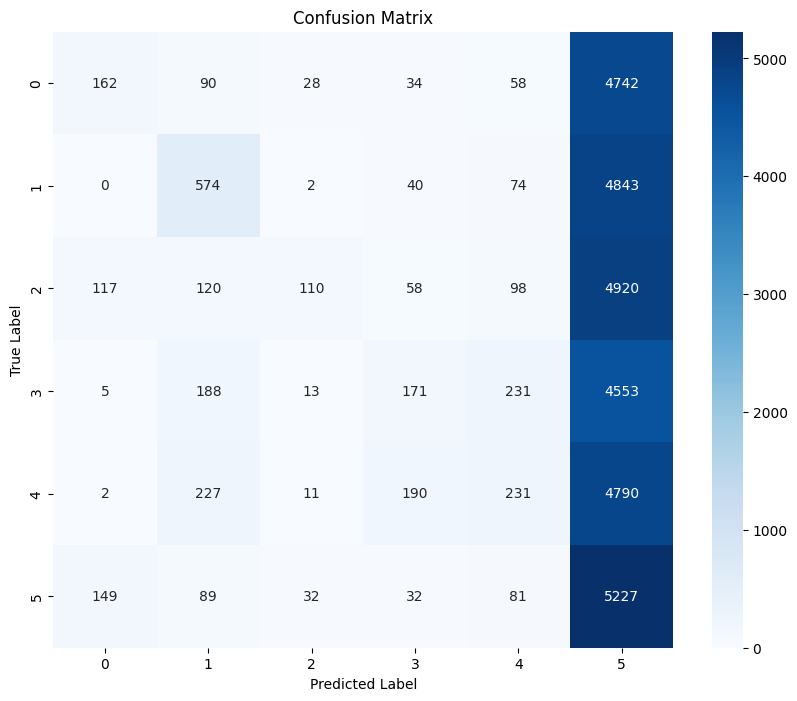

In [75]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()